# Visualisation and Analysis of Altcoins

## Structure of notebook
### Setup
- Imports and constants
- Data loading and cleaning (from csvs)

### Analysis
- Comparison at exchange level 
    - Number of coins comparison
    - Volume of trade comparison
    - Close price comparison


- Comparison at coin level
    - Shared coins across multiple exchanges and reported trade volume/price
    - Number of low-traded coins
    - Identification of spikes of trading

- Characterising spikes/drops in trade volume


## Imports and Constants

In [177]:
# data processing imports
import numpy as np
from scipy import stats
import pandas as pd
import math
import os
from forex_python.converter import CurrencyRates

# visualisation imports
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
import prettytable

In [178]:
DATA_PATH = "data"
DATA_COLLECTED = ["klines", "trades", "kline_history"]
EXCHANGES = ["huobi", "kucoin", "binance"]
EXCLUDED_COINS = ["BTCUSDT", "ETHUSDT"]
BASE_CURRENCY = "USD"

## Data Loading and Cleaning

1. Loads data from csvs to dictionaries.
2. Normalise the data between exchanges
    - Change coin names to be regular (uppercase, coin name + base coin e.g. BTCUSD)
    - Crop kline data to cover the same time period (same overall start + end time covered)

In [179]:
huobi_col_labels = ["ts", "open", "close", "high", "low", "volume", "amount"]
kucoin_col_labels = ["start_time", "amount", "open", "close", "high", "low", "volume"]
binance_col_labels = ["start_time", "close_time", "open", "close", "high", "low", "volume"]


In [180]:
class LoadData():
    def __init__(self, exchange, path_to_folder, metric = None, symbol = None):
        self.exchange = exchange
        self.metric = metric # if None, load all metrics
        self.symbol = symbol # if None, load all symbols
        self.path_to_folder = path_to_folder
        self.data = self.load_data()
    
    def _check_if_file_empty(self, file_path):
        """Checks if a file is empty"""
        return os.stat(file_path).st_size == 0
    
    def _add_col_labels(self, data, col_labels):
        """Adds column labels to a dataframe"""
        data.columns = col_labels
        return data

    def _load_data(self, metric, path_to_folder):
        """Loads data from csv files into a dictionary of dataframes"""
        data = {}
        if self.symbol is None:
            # for every csv file in the folder, load it into a dataframe
            for file in os.listdir("{path_to_folder}/{exchange}/{metric}".format(path_to_folder=path_to_folder, exchange=self.exchange, metric=metric)):
                # get the symbol from the csv file name
                symbol = file.split(".")[0]
                # check not empty
                if self._check_if_file_empty(f"{path_to_folder}/{self.exchange}/{metric}/{symbol}.csv"):
                    continue
                # load the csv file into a dataframe
                #print(f"Loading {symbol} {metric} data from {self.exchange}...")
                data[symbol] = pd.read_csv(f"{path_to_folder}/{self.exchange}/{metric}/{symbol}.csv")
        else:
            data[self.symbol] = pd.read_csv(f"{path_to_folder}/{metric}/{self.symbol}.csv")
        # add column labels
        if self.exchange == "huobi":
            for symbol in data:
                data[symbol] = self._add_col_labels(data[symbol], huobi_col_labels)
        elif self.exchange == "kucoin":
            for symbol in data:
                data[symbol] = self._add_col_labels(data[symbol], kucoin_col_labels)
        elif self.exchange == "binance":
            for symbol in data:
                data[symbol] = self._add_col_labels(data[symbol], binance_col_labels)
        return data


    def load_data(self, path_to_folder = None):
        """Loads data from csv files into a dictionary of dataframes"""
        if path_to_folder is None:
            path_to_folder = self.path_to_folder
        
        data = {}
        if self.metric is None:
            for metric in DATA_COLLECTED:
                data[metric] = self._load_data(metric, path_to_folder)
        else:
            data[self.metric] = self._load_data(self.metric, path_to_folder)
        return data

    def get_data(self):
        return self.data

In [181]:
class NormaliseDataFactory():
    def __init__(self, exchange: str, data: dict, metric: str, symbol: str = None):
        self.exchange = exchange
        self.metric = metric
        self.symbol = symbol
        self.data = data
    
    def normalise_data(self):
        if self.exchange == "huobi":
            return NormaliseHuobiData(self.exchange, self.data, self.metric, self.symbol).get_normalised_data()
        elif self.exchange == "kucoin":
            return NormaliseKucoinData(self.exchange, self.data, self.metric, self.symbol).get_normalised_data()
        elif self.exchange == "binance":
            return NormaliseBinanceData(self.exchange, self.data, self.metric, self.symbol).get_normalised_data()
        else:
            raise NotImplementedError


class NormaliseData():
    def __init__(self, exchange: str, data: dict, metric: str, symbol: str):
        self.exchange = exchange
        self.data = data
        self.metric = metric
        self.symbol = symbol
        self.normalised_data = self.normalise_data()

    def _normalise_data(self, data: pd.DataFrame):
        pass

    def _normalise_symbol(self, symbol: str):
        pass

    def _convert_timestamp(self, data: pd.DataFrame):
        pass
    
    def normalise_data(self):
        pass

    def get_normalised_data(self):
        return self.normalised_data
    
    def get_normalised_data_as_df(self):
        return pd.DataFrame(self.normalised_data)
    

class NormaliseHuobiData(NormaliseData):
    def __init__(self, exchange: str, data: dict, metric: str, symbol: str):
        super().__init__(exchange, data, metric, symbol)

    def normalise_data(self):
        normalised_data = {}
        for symbol in self.data.keys():
            new_symbol = self._normalise_symbol(symbol)
            normalised_data[new_symbol] = self._normalise_data(self.data[symbol])
        return normalised_data
    
    def _normalise_symbol(self, symbol: str):
        # remove kline interval from symbol
        symbol = symbol.split("_")[0]
        # uppercase symbol
        symbol = symbol.upper()
        return symbol

    def _normalise_data(self, data: pd.DataFrame):
        data.columns = huobi_col_labels
        
        self._convert_timestamp(data)
        # convert timestamp to datetime
        data["ts"] = pd.to_datetime(data["ts"], unit="ms")
        # convert all other columns to float
        data["open"] = data["open"].astype(float)
        data["high"] = data["high"].astype(float)
        data["low"] = data["low"].astype(float)
        data["close"] = data["close"].astype(float)
        data["volume"] = data["volume"].astype(float)
        data["amount"] = data["amount"].astype(float)
        return data
    
    def _convert_timestamp(self, data: pd.DataFrame):
        # example valid timestamp: 1675843200000
        # example invalid timestamp: 1678752000
        # pad to 13 digits
        data["ts"] = data["ts"].apply(lambda x: x * 1000 if len(str(x)) == 10 else x)

        return data
    

class NormaliseKucoinData(NormaliseData):
    def __init__(self, exchange: str, data: dict, metric: str, symbol: str):
        super().__init__(exchange, data, metric, symbol)

    def normalise_data(self):
        normalised_data = {}
        for symbol in self.data.keys():
            new_symbol = self._normalise_symbol(symbol)
            normalised_data[new_symbol] = self._normalise_data(self.data[symbol])
        return normalised_data
    
    def _normalise_symbol(self, symbol: str):
        # remove kline interval from symbol
        symbol = symbol.split("_")[0]
        # remove hyphen
        symbol = symbol.replace("-", "")
        # uppercase symbol
        symbol = symbol.upper()
        return symbol
    
    def _normalise_data(self, data: pd.DataFrame):
        data.columns = kucoin_col_labels
        #kucoin_col_labels = ["start_time", "open", "close", "high", "low", "volume", "amount"]

        # pad start and close times to 13 digits
        data = self._convert_timestamp(data)

        # convert timestamp to datetime
        data["start_time"] = pd.to_datetime(data["start_time"], unit="ms")
        data["open"] = data["open"].astype(float)
        data["high"] = data["high"].astype(float)
        data["low"] = data["low"].astype(float)
        data["close"] = data["close"].astype(float)
        data["volume"] = data["volume"].astype(float)
        data["amount"] = data["amount"].astype(float)


        return data
    
    def _convert_timestamp(self, data: pd.DataFrame):
        # example valid timestamp: 1675843200000
        # example invalid timestamp: 1679425200
        # convert from 10 (seconds) to 13 (milliseconds) digits
        data["start_time"] = data["start_time"].apply(lambda x: x * 1000 if len(str(x)) == 10 else x)

        return data
    

class NormaliseBinanceData(NormaliseData):
    def __init__(self, exchange: str, data: dict, metric: str, symbol: str):
        super().__init__(exchange, data, metric, symbol)

    def normalise_data(self):
        normalised_data = {}
        for symbol in self.data.keys():
            new_symbol = self._normalise_symbol(symbol)
            normalised_data[new_symbol] = self._normalise_data(self.data[symbol])
        return normalised_data
    
    def _normalise_symbol(self, symbol: str):
        # remove kline interval from symbol
        symbol = symbol.split("_")[0]
        # remove hyphen
        symbol = symbol.replace("-", "")
        # uppercase symbol
        symbol = symbol.upper()
        return symbol
    
    def _normalise_data(self, data: pd.DataFrame):
        data.columns = binance_col_labels
        #binance_col_labels = ["start_time", "close_time", "open", "close", "high", "low", "volume"]

        # convert timestamp to datetime
        data["start_time"] = pd.to_datetime(data["start_time"], unit="ms")
        data["close_time"] = pd.to_datetime(data["close_time"], unit="ms")
        data["open"] = data["open"].astype(float)
        data["high"] = data["high"].astype(float)
        data["low"] = data["low"].astype(float)
        data["close"] = data["close"].astype(float)
        data["volume"] = data["volume"].astype(float)
        return data

time_col_by_exchange = {
    "huobi": "ts",
    "binance": "start_time",
    "kucoin": "start_time"
} # TODO MOVE 

class FilterData():
    def __init__(self):
        pass
    
    def filter_data_to_same_timeframe(self, data: dict):
        # get symbol with latest first timestamp
        # and earliest last timestamp
        """
        latest_start_time = pd.Timestamp(0)
        for exchange in data.keys():
            index = time_col_by_exchange[exchange]
            for symbol in data[exchange].keys():
                if data[exchange][symbol][index].iloc[0] > latest_start_time:
                    latest_start_time = data[exchange][symbol][index].iloc[0]
        
        earliest_end_time = pd.Timestamp.now()
        for exchange in data.keys():
            index = time_col_by_exchange[exchange]
            for symbol in data[exchange].keys():
                if data[exchange][symbol][index].iloc[-1] < earliest_end_time:
                    earliest_end_time = data[exchange][symbol][index].iloc[-1]

        # filter data to same timeframe
        for exchange in data.keys():
            index = time_col_by_exchange[exchange]
            for symbol in data[exchange].keys():
                for i, row in data[exchange][symbol].iterrows():
                    if row[index] < latest_start_time or row[index] > earliest_end_time:
                        data[exchange][symbol] = data[exchange][symbol].drop(i)
        print(data)
        """
        return data
    
    def filter_excluded_coins(self, data: dict, excluded_coins: list):
        for exchange in data.keys():
            for symbol in excluded_coins:
                if symbol in data[exchange].keys():
                    del data[exchange][symbol]
        return data



In [182]:
"""Normalise currencies
Each coin has a different base currency, e.g. BTC, ETH, USDT
We want to normalise all coins to the same base currency - USD
"""

class NormaliseCurrencies():
    def __init__(self, exchange: str, data: dict, base_currency = "USD"):
        self.exchange = exchange
        self.data = data
        self.base_currency = base_currency
        self.fiat_currencies = self._get_fiat_currencies()
        self.norm_data = {}

    def normalise_currencies(self):
        for symbol in self.data.keys():
            self.norm_data[symbol] = self._normalise_currency(symbol)
        return self.norm_data
    
    def _get_fiat_currencies(self):
        # get list of fiat currencies
        c = CurrencyRates()
        return c.get_rates("USD").keys()
    
    def _get_fiat_price(self, currency: str, time: pd.Timestamp):
        # get price of fiat currency in base currency
        c = CurrencyRates()
        try:
            return c.get_rate(currency, self.base_currency, time)
        except:
            return c.get_rate(currency, self.base_currency)
        
    def _get_coin_price(self, currency: str, time: pd.Timestamp):
        # convert the coin into other coins until we reach BTCUSD
        # then convert to base currency
        
        # append USD to symbol and check if it exists
        symbol = currency + "USD"
        if symbol in self.data.keys():
            return self.data[symbol]["close"][time]
        # otherwise check common pairs
        pairs = ["BTC", "ETH", "USDT"]
        for pair in pairs:
            # append pair to symbol and check if it exists
            symbol = currency + pair
            if symbol in self.data.keys():
                # get price of pair in base currency
                if pair == self.base_currency:
                    price = 1
                else:
                    price = self._get_price(pair, time)
                # get price of coin in pair
                coin_price = self.data[symbol]["close"][time]
                # return price of coin in base currency
                return coin_price * price
        # if no pairs found, return 0
        return 0
    
    def _get_price(self, currency: str, time: pd.Timestamp):
        # the currency can either be a fiat currency or a coin
        # if fiat, use forex-python to get price
        # if coin, use ccxt to get price
        if currency in self.fiat_currencies:
            price = self._get_fiat_price(currency, time)
        else:
            price = self._get_coin_price(currency, time)
        return price

    
    def _normalise_currency(self, symbol: str):
        # get currency of symbol
        currency = symbol[-3:]
        # get symbol without currency
        symbol = symbol[:-3]
        # get price of symbol in base currency
        if currency == self.base_currency:
            price = 1
        else:
            price = self._get_price(symbol, currency)
        # normalise data
        data = self.data[symbol]
        data["open"] = data["open"] * price
        data["high"] = data["high"] * price
        data["low"] = data["low"] * price
        data["close"] = data["close"] * price
        return data


In [183]:
# Load kline data
huobi_data = LoadData(exchange="huobi", path_to_folder=DATA_PATH, metric="kline_history").get_data()
kucoin_data = LoadData(exchange="kucoin", path_to_folder=DATA_PATH, metric="kline_history").get_data()
binance_data = LoadData(exchange="binance", path_to_folder=DATA_PATH, metric="kline_history").get_data()

In [184]:
# Normalise data
huobi_normalised_data = NormaliseDataFactory(exchange="huobi", metric="kline_history", data=huobi_data["kline_history"]).normalise_data()
kucoin_normalised_data = NormaliseDataFactory(exchange="kucoin", metric="kline_history", data=kucoin_data["kline_history"]).normalise_data()
binance_normalised_data = NormaliseDataFactory(exchange="binance", metric="kline_history", data=binance_data["kline_history"]).normalise_data()

In [185]:
# Filter data to same timeframe
filtered_data = FilterData().filter_data_to_same_timeframe(data={"huobi": huobi_normalised_data, "kucoin": kucoin_normalised_data, "binance": binance_normalised_data})
huobi_filtered = filtered_data["huobi"]
kucoin_filtered = filtered_data["kucoin"]
binance_filtered = filtered_data["binance"]

In [187]:
# Filter excluded coins
filtered_data = FilterData().filter_excluded_coins(data={"huobi": huobi_filtered, "kucoin": kucoin_filtered, "binance": binance_filtered}, excluded_coins=EXCLUDED_COINS)

In [188]:
# Merge data
merged_data = {"huobi": huobi_filtered, "kucoin": kucoin_filtered, "binance": binance_filtered}

## Analysis

### Characterise Dataset
- Number of exchanges
- Number of coins (total)
- Number of klines (total)
- Earliest time and latest time

In [208]:
# get number of exchanges
num_exchanges = len(merged_data.keys())

# get number of coins
num_coins = 0
for exchange in merged_data.keys():
    num_coins += len(merged_data[exchange].keys())

# get total number of data points
num_data_points = 0
for exchange in merged_data.keys():
    for symbol in merged_data[exchange].keys():
        num_data_points += len(merged_data[exchange][symbol]["open"])

# get earliest and latest date
earliest_date = pd.Timestamp("now")
latest_date = pd.Timestamp("1970-01-01")
for exchange in merged_data.keys():
    for symbol in merged_data[exchange].keys():
        if merged_data[exchange][symbol][time_col_by_exchange[exchange]].index[0] < earliest_date:
            earliest_date = merged_data[exchange][symbol][time_col_by_exchange[exchange]].index[0]
        if merged_data[exchange][symbol][time_col_by_exchange[exchange]].index[-1] > latest_date:
            latest_date = merged_data[exchange][symbol][time_col_by_exchange[exchange]].index[-1]

# get number of days
num_days = (latest_date - earliest_date).days

# get number of data points per day
num_data_points_per_day = num_data_points / num_days

# get number of data points per coin
num_data_points_per_coin = num_data_points / num_coins

# get number of data points per exchange
num_data_points_per_exchange = num_data_points / num_exchanges

print("Number of exchanges: {}".format(num_exchanges))
print("Number of coins: {}".format(num_coins))
print("Number of data points: {}".format(num_data_points))
print("Earliest date: {}".format(earliest_date))
print("Latest date: {}".format(latest_date))
print("Number of days: {}".format(num_days))
print("Number of data points per day: {}".format(num_data_points_per_day))
print("Number of data points per coin: {}".format(num_data_points_per_coin))
print("Number of data points per exchange: {}".format(num_data_points_per_exchange))


KeyError: 'start_time'

### Comparison of Exchanges

- Number of coins (+ shared coins)
- Volume of trade
- Close prices of coins

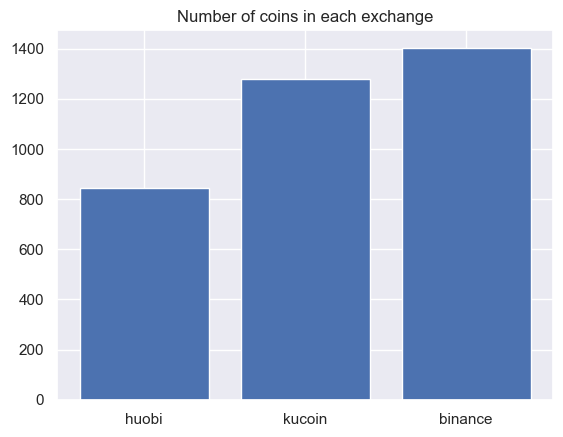

In [189]:
def plot_number_of_coins(data: list):
    """Plots the number of coins in each exchange"""
    # use seaborn style
    sns.set()
    num_exchanges = len(data)
    plt.bar(EXCHANGES, [len(data[i]) for i in range(num_exchanges)])
    plt.title("Number of coins in each exchange")
    plt.show()

list_data = list(merged_data.values())
plot_number_of_coins(list_data)

Shared coins between all three exchanges: 407


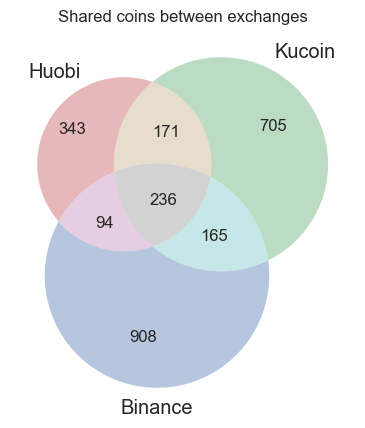

In [190]:
# Get shared coins between exchanges

def get_shared_coins(exchange_a_data: list, exchange_b_data: list):
    """Returns a list of shared coins between two exchanges"""
    shared_coins = []
    for coin in exchange_a_data.keys():
        if coin in exchange_b_data.keys():
            shared_coins.append(coin)
    return shared_coins

def get_shared_coins_between_exchanges(data: list):
    """Returns a list of shared coins between all exchanges"""
    shared_coins = []
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            shared_coins.append(get_shared_coins(data[i], data[j]))
    return shared_coins

shared_all_three = get_shared_coins_between_exchanges(list_data)
shared_huobi_kucoin = get_shared_coins(merged_data["huobi"], merged_data["kucoin"])
shared_huobi_binance = get_shared_coins(merged_data["huobi"], merged_data["binance"])
shared_kucoin_binance = get_shared_coins(merged_data["kucoin"], merged_data["binance"])

print("Shared coins between all three exchanges: {}".format(len(shared_all_three[0])))

# Venn diagram of shared coins between exchanges
plt.figure(figsize=(5, 5))
venn3([set(merged_data["huobi"]), set(merged_data["kucoin"]), set(merged_data["binance"])], set_labels = ("Huobi", "Kucoin", "Binance"))
plt.title("Shared coins between exchanges")
plt.show()

## Comparison of volume for each exchange

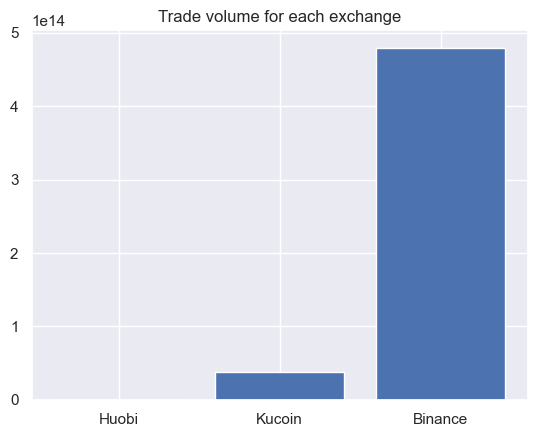

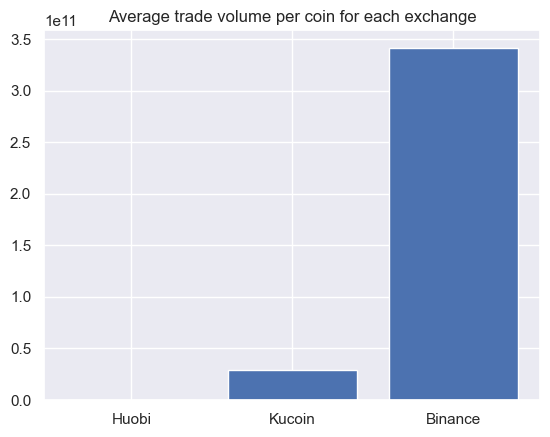

Top 10 coins by trade volume on Huobi
+----------+--------------------+---------------------+
|   Coin   |    Trade volume    |    Average price    |
+----------+--------------------+---------------------+
| USDCUSDT | 674311971.0221605  |  0.9963486486486609 |
| XRPUSDT  | 543196342.7399001  | 0.38061372372372415 |
| BLURUSDT |  483181290.877199  |  0.7726703309692668 |
| USDDUSDT | 401836866.6130939  |  0.9936919619619615 |
| BTCUSDD  | 346725322.98166114 |  23637.022642642612 |
| TRXUSDT  | 338916433.4945036  | 0.06676259459459455 |
| COREUSDT | 325616705.75508696 |  2.8008663266533036 |
| ETHUSDD  | 268502060.70411265 |  1629.6394494494525 |
| NEARUSDT | 268357342.48912752 |  2.2088140140140133 |
|  HTUSDT  | 253995949.39670226 |  4.855752152152148  |
+----------+--------------------+---------------------+
Top 10 coins by trade volume on Kucoin
+-----------+--------------------+------------------------+
|    Coin   |    Trade volume    |     Average price      |
+-----------+------

In [191]:
# Trade volume for each exchange

def get_trade_volume(data: dict):
    """Returns the trade volume of each coin"""
    trade_volume = 0
    for coin in data.keys():
        if coin not in EXCLUDED_COINS:
            trade_volume += data[coin]["volume"].sum()
    return trade_volume

huobi_trade_volume = get_trade_volume(merged_data["huobi"])
kucoin_trade_volume = get_trade_volume(merged_data["kucoin"])
binance_trade_volume = get_trade_volume(merged_data["binance"])

def plot_trade_volume(data: dict, title: str = "Trade volume for each exchange"):
    """Plots the trade volume of each coin"""
    plt.bar(data.keys(), data.values())
    plt.title(title)
    plt.show()

aggregated_vols = {"Huobi": huobi_trade_volume, "Kucoin": kucoin_trade_volume, "Binance": binance_trade_volume}
plot_trade_volume(aggregated_vols)

# Plot average trade volume per coin for each exchange
huobi_avg_vol = huobi_trade_volume / len(merged_data["huobi"])
kucoin_avg_vol = kucoin_trade_volume / len(merged_data["kucoin"])
binance_avg_vol = binance_trade_volume / len(merged_data["binance"])

avg_vols = {"Huobi": huobi_avg_vol, "Kucoin": kucoin_avg_vol, "Binance": binance_avg_vol}
plot_trade_volume(avg_vols, title="Average trade volume per coin for each exchange")

# Plot table with top 10 coins by trade volume for each exchange
def get_top_coins_by_trade_volume(data: dict, num_coins: int = 10):
    """Returns a dict of the top coins by trade volume"""
    top_coins = {}
    for coin in data.keys():
        top_coins[coin] = data[coin]["volume"].sum()
    top_coins = dict(sorted(top_coins.items(), key=lambda item: item[1], reverse=True)[:num_coins])
    return top_coins

huobi_top_vol_coins = get_top_coins_by_trade_volume(merged_data["huobi"])
kucoin_top_vol_coins = get_top_coins_by_trade_volume(merged_data["kucoin"])
binance_top_vol_coins = get_top_coins_by_trade_volume(merged_data["binance"])

def plot_table(data: dict, exchange: str, title: str = "Top 10 coins by trade volume"):
    """Plots a table of the top coins by trade volume"""
    # use prettytable to print table
    table = prettytable.PrettyTable()
    table.field_names = ["Coin", "Trade volume", "Average price"]
    for coin in data.keys():
        table.add_row([coin, data[coin], merged_data[exchange][coin]["close"].mean()])
    print(title)
    print(table)

plot_table(huobi_top_vol_coins, "huobi",  title="Top 10 coins by trade volume on Huobi")
plot_table(kucoin_top_vol_coins, "kucoin", title="Top 10 coins by trade volume on Kucoin")
plot_table(binance_top_vol_coins, "binance", title="Top 10 coins by trade volume on Binance")




## Close prices for each exchange

In [202]:
# Histogram of close price for each exchange

def plot_histogram(data: list, title: str = "Histogram of close price for each exchange"):
    """Plots a histogram of the close price for each coin in each exchange"""
    # use seaborn to make the histogram look nicer
    sns.set()
    plt.hist(data)
    
    plt.title(title)
    plt.xlabel("Close price")
    plt.ylabel("Number of coins")
    
    plt.show()

huobi_close_prices = [merged_data["huobi"][coin]["close"].iloc[-1] for coin in merged_data["huobi"].keys()]
kucoin_close_prices = [merged_data["kucoin"][coin]["close"].iloc[-1] for coin in merged_data["kucoin"].keys()]
binance_close_prices = [merged_data["binance"][coin]["close"].iloc[-1] for coin in merged_data["binance"].keys()]

#plot_histogram(huobi_close_prices, title="Huobi")
#plot_histogram(kucoin_close_prices, title="Kucoin")
#plot_histogram(binance_close_prices, title="Binance")

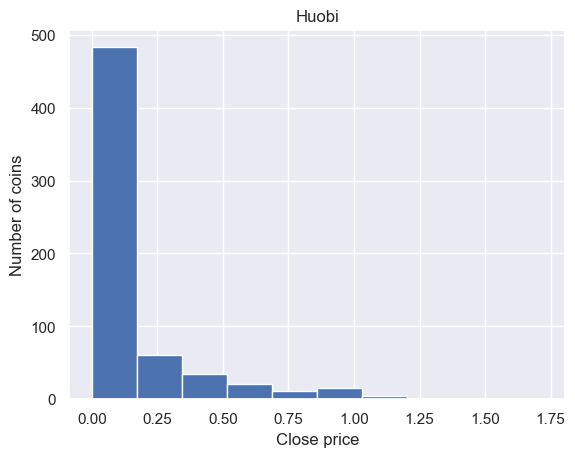

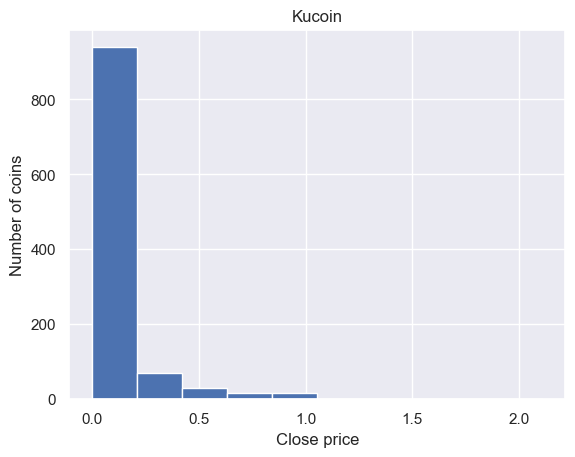

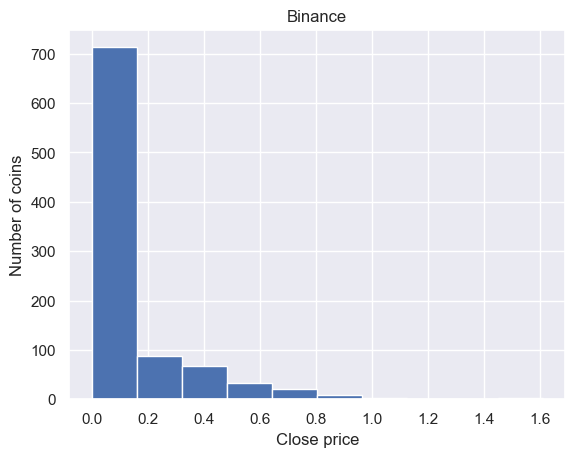

In [204]:
# Show more detailed histogram of close prices for very low prices
# - Not a good analysis as the base prices are in different currencies
# - Just for illustration of the huge bar of coins with close price ~0   

def filter_high_priced_coins(data: pd.DataFrame, threshold: float):
    # remove coins with close price over threshold
    new_data = {}
    removed = {}
    for coin in data.keys():
        if data[coin]["close"][0] < threshold:
            new_data[coin] = data[coin]
        else: 
            removed[coin] = data[coin]
    return new_data, removed

def create_table_removed_coins(data: pd.DataFrame, threshold: float, exchange: str):
    table = prettytable.PrettyTable()
    table.field_names = ["Coin", "Close price"]
    table.title = "Coins with close price over {} in {}".format(threshold, exchange)
    for coin in data.keys():
        table.add_row([coin, data[coin]["close"][0]])
    print(table)

    
huobi_low_traded, huobi_removed = filter_high_priced_coins(merged_data["huobi"], 1.0)
kucoin_low_traded, kucoin_removed = filter_high_priced_coins(merged_data["kucoin"], 1.0)
binance_low_traded, binance_removed = filter_high_priced_coins(merged_data["binance"], 1.0)

huobi_low_traded_close_prices = [huobi_low_traded[coin]["close"].iloc[-1] for coin in huobi_low_traded.keys()]
kucoin_low_traded_close_prices = [kucoin_low_traded[coin]["close"].iloc[-1] for coin in kucoin_low_traded.keys()]
binance_low_traded_close_prices = [binance_low_traded[coin]["close"].iloc[-1] for coin in binance_low_traded.keys()]

plot_histogram(huobi_low_traded_close_prices, title="Huobi")
plot_histogram(kucoin_low_traded_close_prices, title="Kucoin")
plot_histogram(binance_low_traded_close_prices, title="Binance")

#create_table_removed_coins(huobi_removed, 1.0, "Huobi")
#create_table_removed_coins(kucoin_removed, 1.0, "Kucoin")
#create_table_removed_coins(binance_removed, 1.0, "Binance")


## Statistics on volume traded per exchange

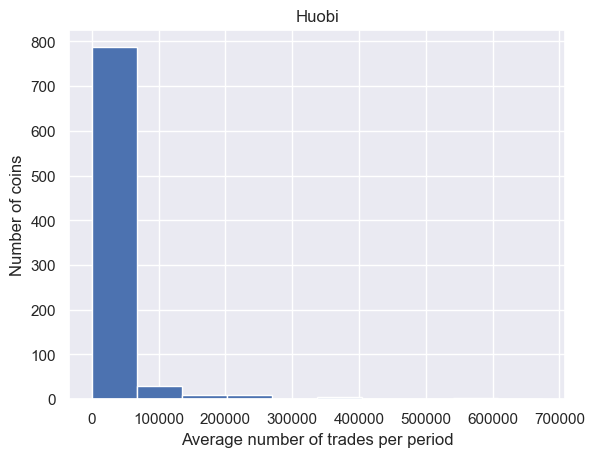

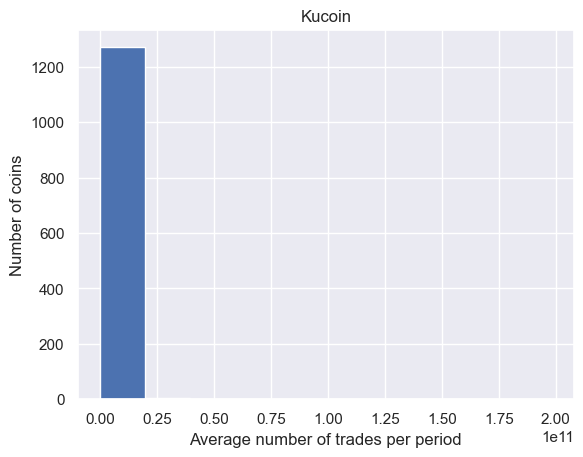

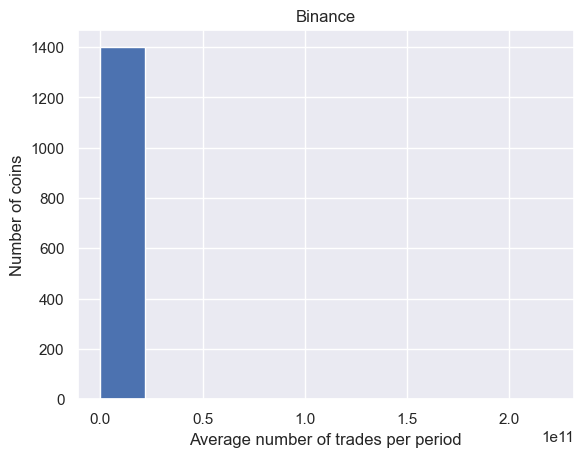

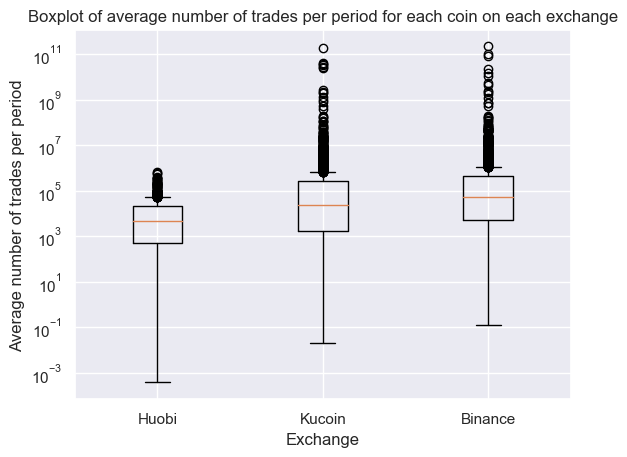

+--------------------------------------------------------------------------------------------------+
| Mean, std, skew, kurtosis for average number of trades per period for each coin on each exchange |
+----------+---------------------+--------------------+--------------------+-----------------------+
| Exchange |         Mean        |        Std         |        Skew        |        Kurtosis       |
+----------+---------------------+--------------------+--------------------+-----------------------+
|  Huobi   |  21361.271911649572 | 54935.07086733238  | 6.434306353349113  |   53.77147675936805   |
|  Kucoin  |  296945316.2703683  |  5934225806.89501  | 29.74816716240868  |   967.5476590847243   |
| Binance  |  342027303.3837707  | 6915319530.683682  | 26.62163903578444  |   778.4282996936872   |
+----------+---------------------+--------------------+--------------------+-----------------------+
\begin{tabular}{ccccc}
Exchange & Mean & Std & Skew & Kurtosis \\
Huobi & 21361.27191164957

In [206]:
# Get average number of trades per period for each coin on each exchange
def get_avg_trades_per_period(dataset: pd.DataFrame):
    """Returns a list of the average number of trades per period for each coin"""
    avg_trades_per_period = []
    for coin in dataset.keys():
        avg_trades_per_period.append(dataset[coin]["volume"].sum()/len(dataset[coin]["volume"]))
    return avg_trades_per_period

huobi_avg_trades_per_period = get_avg_trades_per_period(merged_data["huobi"])
kucoin_avg_trades_per_period = get_avg_trades_per_period(merged_data["kucoin"])
binance_avg_trades_per_period = get_avg_trades_per_period(merged_data["binance"])

# Plot histogram of average number of trades per period for each coin on each exchange
def plot_histogram_avg_trades_per_period(data: dict, title: str = "Histogram of average number of trades per period for each coin on each exchange"):
    """Plots a histogram of the average number of trades per period for each coin on each exchange"""
    # use seaborn to make the histogram look nicer
    sns.set()
    plt.hist(data)
    plt.title(title)
    plt.xlabel("Average number of trades per period")
    plt.ylabel("Number of coins")
    
    plt.show()

plot_histogram_avg_trades_per_period(huobi_avg_trades_per_period, title="Huobi")
plot_histogram_avg_trades_per_period(kucoin_avg_trades_per_period, title="Kucoin")
plot_histogram_avg_trades_per_period(binance_avg_trades_per_period, title="Binance")

# plot skew kurtosis and mean for all exchanges in boxplots
def plot_boxplot_avg_trades_per_period(data: dict, title: str = "Boxplot of average number of trades per period for each coin on each exchange"):
    """Plots a boxplot of the average number of trades per period for each coin on each exchange"""
    # use seaborn to make the histogram look nicer
    sns.set()
    plt.boxplot(data.values())

    # logarithmic scale on y axis
    plt.yscale("log")
    
    plt.title(title)
    plt.xlabel("Exchange")
    plt.ylabel("Average number of trades per period")
    plt.xticks(range(1, len(data.keys())+1), data.keys())

    plt.show()
     
plot_boxplot_avg_trades_per_period({"Huobi": huobi_avg_trades_per_period, "Kucoin":kucoin_avg_trades_per_period, "Binance":binance_avg_trades_per_period}, title="Boxplot of average number of trades per period for each coin on each exchange")

# plot table of mean, std, skew, kurtosis for each exchange
def create_table_avg_trades_per_period(data: dict):
    table = prettytable.PrettyTable()
    table.field_names = ["Exchange", "Mean", "Std", "Skew", "Kurtosis"]
    table.title = "Mean, std, skew, kurtosis for average number of trades per period for each coin on each exchange"
    for exchange in data.keys():
        table.add_row([exchange, np.mean(data[exchange]), np.std(data[exchange]), stats.skew(data[exchange]), stats.kurtosis(data[exchange])])
    print(table)
    # display table in latex format
    print(table.get_latex_string())
    

create_table_avg_trades_per_period({"Huobi": huobi_avg_trades_per_period, "Kucoin":kucoin_avg_trades_per_period, "Binance":binance_avg_trades_per_period})


## Characterising drops in trade volume

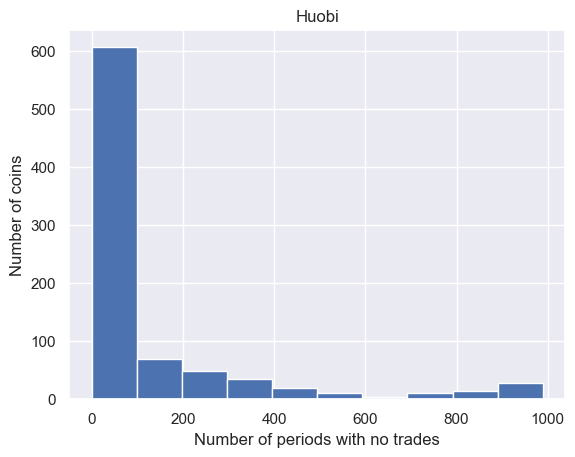

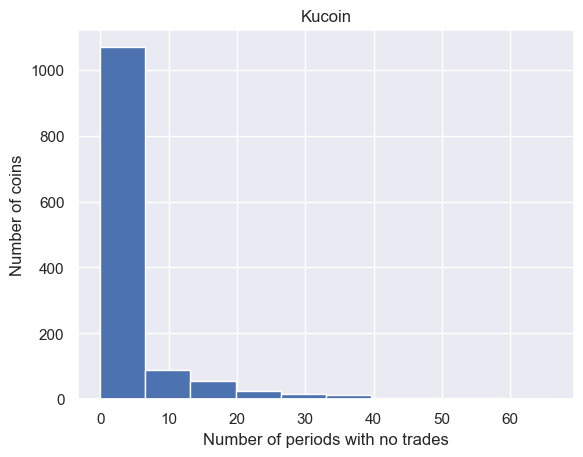

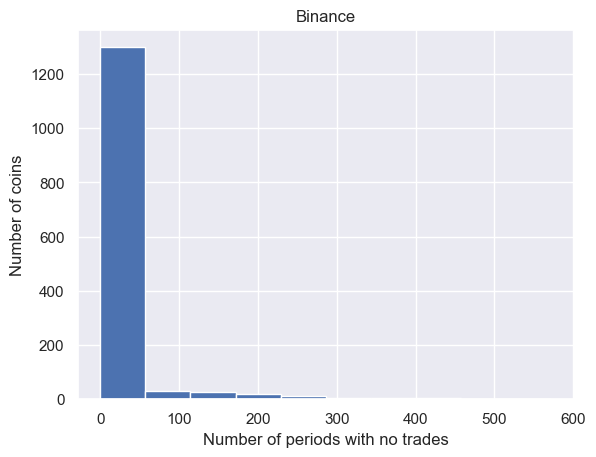

In [194]:
# Plot histogram of periods with no trades for each coin on each exchange
def plot_histogram_periods_no_trades(data: dict, title: str = "Histogram of periods with no trades for each coin on each exchange"):
    """Plots a histogram of the periods with no trades for each coin on each exchange"""
    # use seaborn to make the histogram look nicer
    sns.set()
    plt.hist(data)
    plt.title(title)
    plt.xlabel("Number of periods with no trades")
    plt.ylabel("Number of coins")
    
    plt.show()

def get_periods_of_no_trades(data: pd.DataFrame):
    """Returns a list of the number of periods with no trades for each coin"""
    # .isna() doesn't work -> volume is a float
    # need to detect when volume is 0

    periods_no_trades = []
    for coin in data.keys():
        periods_no_trades.append(data[coin]["volume"].eq(0).sum())
    return periods_no_trades

huobi_periods_no_vol = get_periods_of_no_trades(merged_data["huobi"])
kucoin_periods_no_vol = get_periods_of_no_trades(merged_data["kucoin"])
binance_periods_no_vol = get_periods_of_no_trades(merged_data["binance"])

plot_histogram_periods_no_trades(huobi_periods_no_vol, title="Huobi")
plot_histogram_periods_no_trades(kucoin_periods_no_vol, title="Kucoin")
plot_histogram_periods_no_trades(binance_periods_no_vol, title="Binance")

# Show in detail the coins with 0-50 periods with no trades

def filter_coins_with_no_trades(data: pd.DataFrame, threshold: int):
    # remove coins with close price over threshold
    new_data = {}
    removed = {}
    for coin in data.keys():
        if data[coin]["volume"].eq(0).sum() < threshold:
            new_data[coin] = data[coin]
        else: 
            removed[coin] = data[coin]
    return new_data, removed

huobi_low_traded, huobi_removed = filter_coins_with_no_trades(merged_data["huobi"], 50)
kucoin_low_traded, kucoin_removed = filter_coins_with_no_trades(merged_data["kucoin"], 50)
binance_low_traded, binance_removed = filter_coins_with_no_trades(merged_data["binance"], 50)

huobi_low_traded_periods_no_vol = get_periods_of_no_trades(huobi_low_traded)
kucoin_low_traded_periods_no_vol = get_periods_of_no_trades(kucoin_low_traded)
binance_low_traded_periods_no_vol = get_periods_of_no_trades(binance_low_traded)

#plot_histogram_periods_no_trades(huobi_low_traded_periods_no_vol, title="Huobi (0-50 periods with no trades))")
#plot_histogram_periods_no_trades(kucoin_low_traded_periods_no_vol, title="Kucoin (0-50 periods with no trades))")
#plot_histogram_periods_no_trades(binance_low_traded_periods_no_vol, title="Binance (0-50 periods with no trades))")


In [195]:
# Show in detail the coins with 0-10 periods with no trades

huobi_low_traded, huobi_removed = filter_coins_with_no_trades(merged_data["huobi"], 10)
kucoin_low_traded, kucoin_removed = filter_coins_with_no_trades(merged_data["kucoin"], 10)
binance_low_traded, binance_removed = filter_coins_with_no_trades(merged_data["binance"], 10)

huobi_low_traded_periods_no_vol = get_periods_of_no_trades(huobi_low_traded)
kucoin_low_traded_periods_no_vol = get_periods_of_no_trades(kucoin_low_traded)
binance_low_traded_periods_no_vol = get_periods_of_no_trades(binance_low_traded)

#plot_histogram_periods_no_trades(huobi_low_traded_periods_no_vol, title="Huobi (0-10 periods with no trades))")
#plot_histogram_periods_no_trades(kucoin_low_traded_periods_no_vol, title="Kucoin (0-10 periods with no trades))")
#plot_histogram_periods_no_trades(binance_low_traded_periods_no_vol, title="Binance (0-10 periods with no trades))")

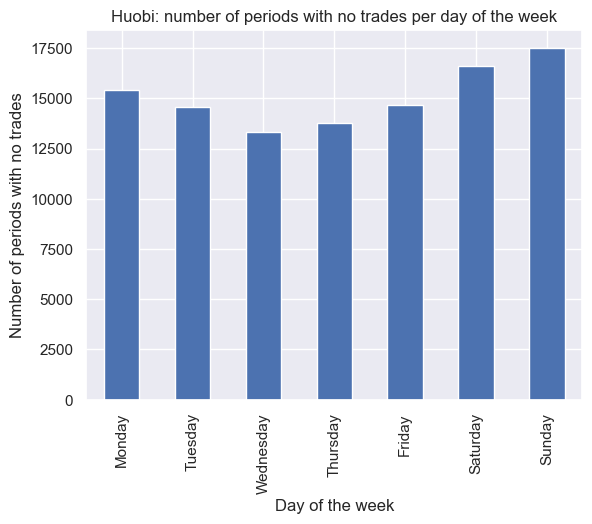

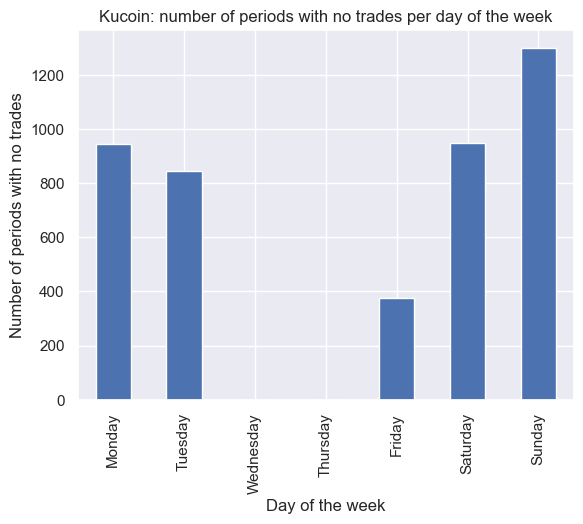

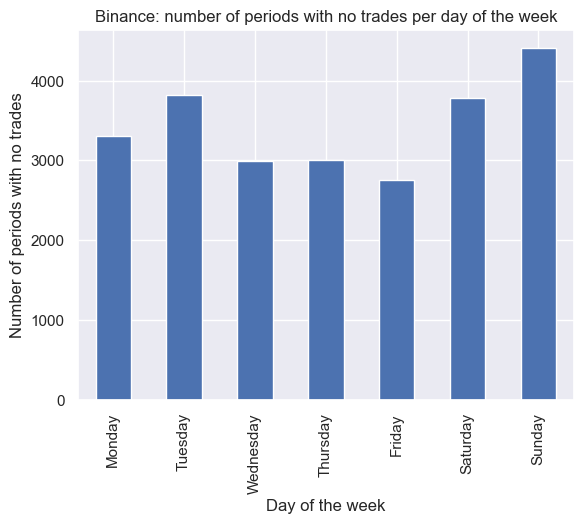

Huobi variance of periods with no trades per day of the week
Skew: 0.578523618853203
Kurtosis: -0.7010831087034815
Kucoin variance of periods with no trades per day of the week
Skew: -0.64436619288695
Kurtosis: 1.9168216893898204
Binance variance of periods with no trades per day of the week
Skew: 0.6012394463935952
Kurtosis: -0.6352692588963489


In [197]:
# Get time of day that periods with no trades occur

def get_time_of_day_no_trades(data: pd.DataFrame):
    """Returns a list of the time of day that periods with no trades occur"""
    # .isna() doesn't work -> volume is a float
    # need to detect when volume is 0

    time_of_day_no_trades = []
    for coin in data.keys():
        # if has column "ts" then use that, otherwise use "close_time"
        if "ts" in data[coin].columns:
            timestamps = data[coin]["ts"].loc[data[coin]["volume"].eq(0)]
        else:
            timestamps = data[coin]["start_time"].loc[data[coin]["volume"].eq(0)]
        for timestamp in timestamps:
            time_of_day_no_trades.append(timestamp.hour)
    
    return time_of_day_no_trades

huobi_time_of_day_no_trades = get_time_of_day_no_trades(merged_data["huobi"])
kucoin_time_of_day_no_trades = get_time_of_day_no_trades(merged_data["kucoin"])
binance_time_of_day_no_trades = get_time_of_day_no_trades(merged_data["binance"])

def get_day_of_the_week(timestamp: pd.Timestamp):
    return timestamp.day_name()

def get_day_of_the_week_no_trades(data: pd.DataFrame):
    """Returns a list of the day of the week that periods with no trades occur"""
    # .isna() doesn't work -> volume is a float
    # need to detect when volume is 0

    day_of_week_no_trades = []
    for coin in data.keys():
        # if has column "ts" then use that, otherwise use "close_time"
        if "ts" in data[coin].columns:
            timestamps = data[coin]["ts"].loc[data[coin]["volume"].eq(0)]
        else:
            timestamps = data[coin]["start_time"].loc[data[coin]["volume"].eq(0)]
        for timestamp in timestamps:
            day_of_week_no_trades.append(get_day_of_the_week(timestamp))
    
    return day_of_week_no_trades

huobi_day_of_week_no_trades = get_day_of_the_week_no_trades(merged_data["huobi"])
kucoin_day_of_week_no_trades = get_day_of_the_week_no_trades(merged_data["kucoin"])
binance_day_of_week_no_trades = get_day_of_the_week_no_trades(merged_data["binance"])

def plot_bar_chart_day_of_week_no_trades(days_of_the_week: list, exchange: str):
    """Plots a bar chart of the number of periods with no trades for each day of the week"""
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    days_of_the_week = pd.Series(days_of_the_week)
    days_of_the_week = days_of_the_week.value_counts().reindex(days)
    days_of_the_week.plot.bar()
    plt.title(exchange + ": number of periods with no trades per day of the week")
    plt.xlabel("Day of the week")
    plt.ylabel("Number of periods with no trades")
    plt.show()

plot_bar_chart_day_of_week_no_trades(huobi_day_of_week_no_trades, "Huobi")
plot_bar_chart_day_of_week_no_trades(kucoin_day_of_week_no_trades, "Kucoin")
plot_bar_chart_day_of_week_no_trades(binance_day_of_week_no_trades, "Binance")

def plot_variance_day_of_week_no_trades(days_of_the_week : list, exchange: str):
    """Plot skew and kurtosis of the number of periods with no trades for each day of the week"""
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    days_of_the_week = pd.Series(days_of_the_week)
    days_of_the_week = days_of_the_week.value_counts().reindex(days)
    print(exchange + " variance of periods with no trades per day of the week")
    print("Skew: " + str(days_of_the_week.skew()))
    print("Kurtosis: " + str(days_of_the_week.kurtosis()))

plot_variance_day_of_week_no_trades(huobi_day_of_week_no_trades, "Huobi")
plot_variance_day_of_week_no_trades(kucoin_day_of_week_no_trades, "Kucoin")
plot_variance_day_of_week_no_trades(binance_day_of_week_no_trades, "Binance")


